Compare the downstream cellchat output of the covid balf dataset, rather than just the embedding to get a better sense of the actual mechanistic differences in outputs. Focus on the "functional" analysis type. 

env: liana

In [148]:
suppressPackageStartupMessages({
    library(CellChat, quietly = T)
    library(patchwork, quietly = T)
    library(RhpcBLASctl, quietly = T)
    library(Matrix, quietly = T)
    library(data.table, quietly = T)
    library(ggplot2, quietly = T)
})
options(stringsAsFactors = FALSE)
# RhpcBLASctl::blas_set_num_threads(25) # no multithreading

# paths
expression_data_path = '/data2/hratch/immune_CCI/covid/expression_data/covid_data/'#'/data2/eric/CCC-Benchmark/data/External/'
external_expression_path = F # set to T if using commented out path , small parsing differences

rev_path = '/data3/hratch/tc2c_analyses_1/natcomm_revisions/'
raw_counts_path<-'/data2/hratch/immune_CCI/covid/expression_data/covid_data/'

# parameters
type_<-'functional'#'structural'
group<-1
seed<-888
set.seed(seed)

if (external_expression_path){
    cell_grouper<-'cell_type'
}else{
    cell_grouper<-'celltype'
}

In [40]:
# get samples
samples<-c()
for (fn in list.files(raw_counts_path)){
    samples<-c(samples, strsplit(fn, '_')[[1]][[2]])
}
samples<-unique(samples)

# load the data
context.map<-list()
sample.expr<-list()
for (sample in samples){
    sample.expr[[sample]][['expr']] = read.csv(paste0(raw_counts_path, 'DGE_', sample, '_External_Tool.csv'), row.names = 1)
    
#     md = read.csv(paste0(raw_counts_path, 'Meta_', sample, '_External_Tool.csv'), row.names = 1)
#     md[['cell.id']]<-row.names(md)
    sample.expr[[sample]][['md']] = read.csv(paste0(raw_counts_path, 'Meta_', sample, '_External_Tool.csv'), row.names = 1)
    
    context = sample.expr[[sample]][['md']][1, 'group']
    sample.expr[[sample]][['context']] = context
    if (context %in% names(context.map)){
        context.map[[context]]<-c(context.map[[context]], sample)
    }else{
        context.map[[context]]<-c(sample)
    }
}

In [106]:
# merge samples from same context into one expression matrix
context.exprs<-list()
context.mds<-list()

for (context in names(context.map)){
    expr<-list()
    md<-list()
    features<-c()
    for (sample in context.map[[context]]){
        expr[[sample]]<-sample.expr[[sample]][['expr']]
        features<-c(features, rownames(expr[[sample]]))
        md[[sample]]<-sample.expr[[sample]][['md']]
    }
    features<-unique(features)
    expr<-lapply(expr, function(x) x[features, ])
    
    context.expr<-do.call("cbind", expr)
    context.md<-do.call('rbind', md)
#     rownames(context.md)<-context.md$cell.id
    
    context.exprs[[context]]<-context.expr
    context.mds[[context]]<-context.md
}

In [ ]:
run_cellchat<-function(expr, md){
    expr<-CellChat::normalizeData(expr)
    cellchat<-createCellChat(object = as(expr, "dgCMatrix"), meta = md[colnames(expr),], 
                                   group.by = cell_grouper)
    cellchat@DB <- CellChatDB.human # human
    
    cellchat <- subsetData(cellchat)
    cellchat <- identifyOverExpressedGenes(cellchat)
    cellchat <-identifyOverExpressedInteractions(cellchat)
    cellchat <- projectData(cellchat, PPI.human)
    
    cellchat <- computeCommunProb(cellchat, raw.use = F, type = 'triMean', trim = NULL, seed.use = seed, 
                                         population.size = T) 
    cellchat <- filterCommunication(cellchat, min.cells = 1) # as in liana
    cellchat <- computeCommunProbPathway(cellchat)
}

In [ ]:
cellchat.contexts<-list()
for (context in names(context.exprs)){
    print(context)
    cellchat.contexts[[context]]<-run_cellchat(expr = context.exprs[[context]], 
                                              md = context.mds[[context]])
}
saveRDS(cellchat.contexts, paste0(rev_path, 'interim/covid_balf_cellchat_grouped.rds'))


In [165]:
cellchat.contexts<-readRDS(paste0(rev_path, 'interim/covid_balf_cellchat_grouped.rds'))
covid<-mergeCellChat(cellchat.contexts, add.names = names(cellchat.contexts))

Merge the following slots: 'data.signaling','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



In [150]:
samples<-rep(NA, 3)
names(samples)<-c('HC', 'M', 'S')
comparisons<-sapply(names(samples), function(n) which(names(covid@net) == n))
combinations<-combn(comparisons, 2)
comparisons<-setNames(names(comparisons), comparisons)

In [151]:
h_ = 20
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

theme = theme(panel.background = element_blank(), 
              panel.border = element_rect(colour = 'black', fill = 'NA'),
         legend.title=element_text(size=22), 
              plot.title = element_text(size = 20, hjust = 0.5), legend.position="none")

plots<-list()
for (col in (1:dim(combinations)[[2]])){
    comparison<-comparisons[as.character(combinations[,col])]
    g<-netVisual_bubble(covid,  comparison = as.numeric(names(comparison)), angle.x = 45) + 
    ggtitle(paste0(comparison, collapse = ' vs ')) + theme
    
    plots[[col]]<-g
}


Comparing communications on a merged object 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Comparing communications on a merged object 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Comparing communications on a merged object 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


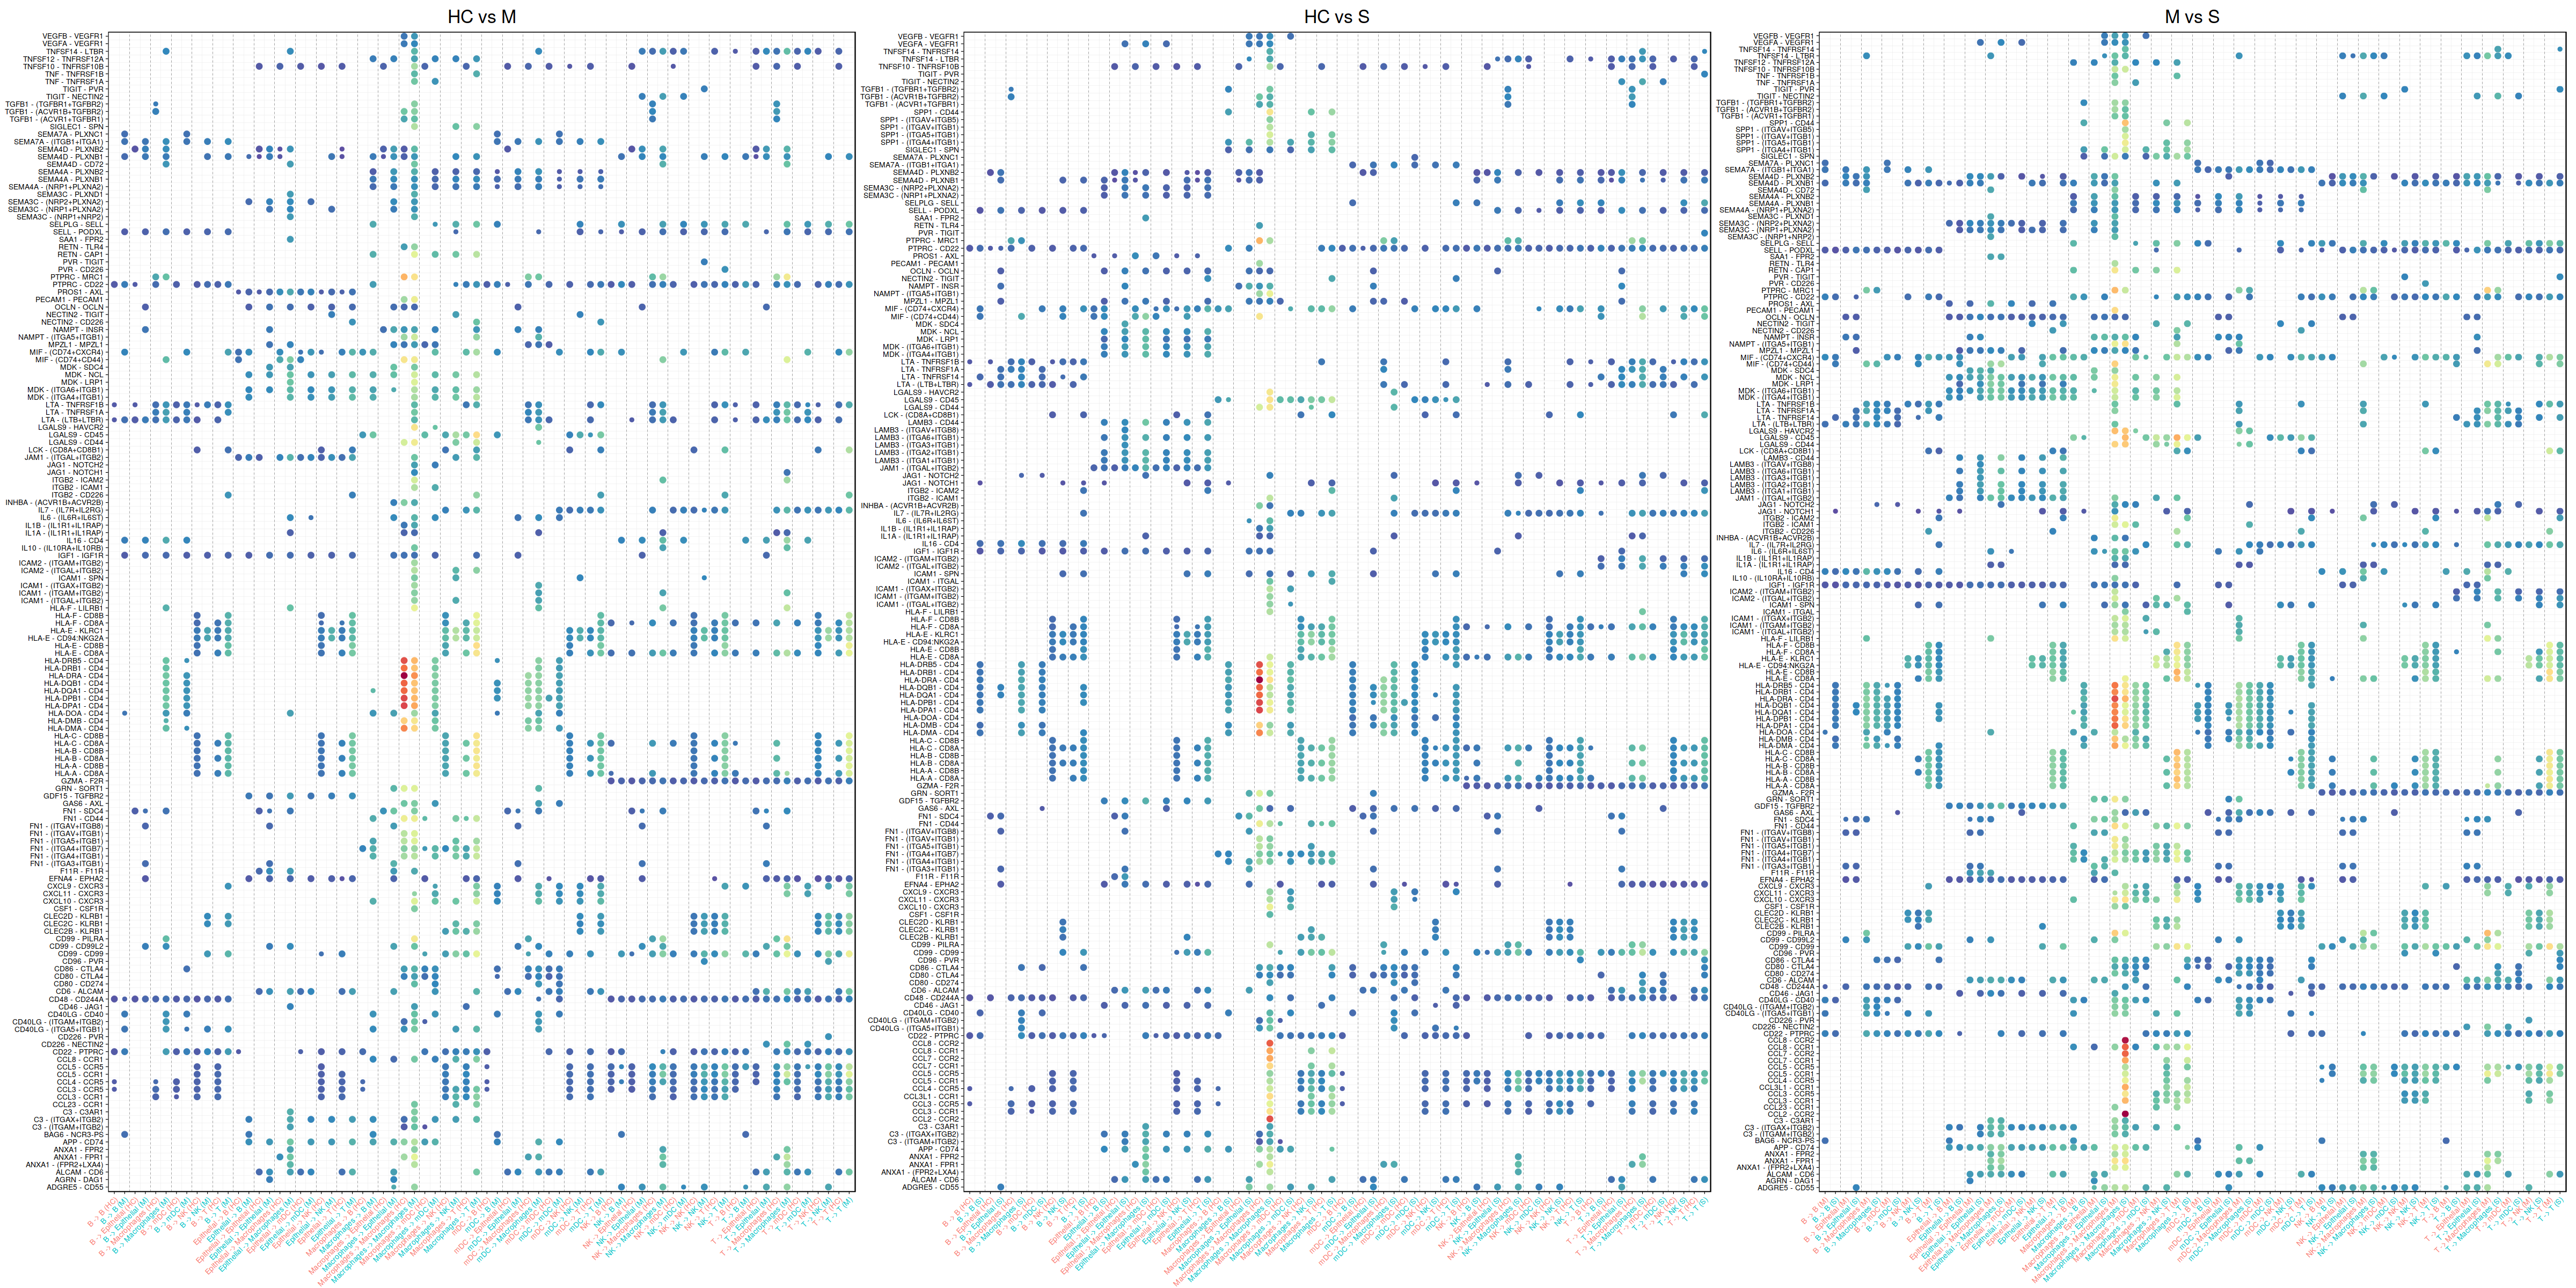

In [216]:
h_ = 20
w_ = 40
options(repr.plot.height=h_, repr.plot.width=w_)
g<-plots[[1]] + plots[[2]] + plots[[3]]
ggsave(paste0(rev_path, 'figures/cellchat_merged_bubbleplot.pdf'), g, height = h_, width = w_)
g

In [166]:
# get UMAP
covid <- computeNetSimilarityPairwise(covid)
covid <- netEmbedding(covid, type = 'functional')
covid<-netClustering(covid, type = "functional")

Compute signaling network similarity for datasets 1 2 3 


2D visualization of signaling networks from datasets 1 2 3 


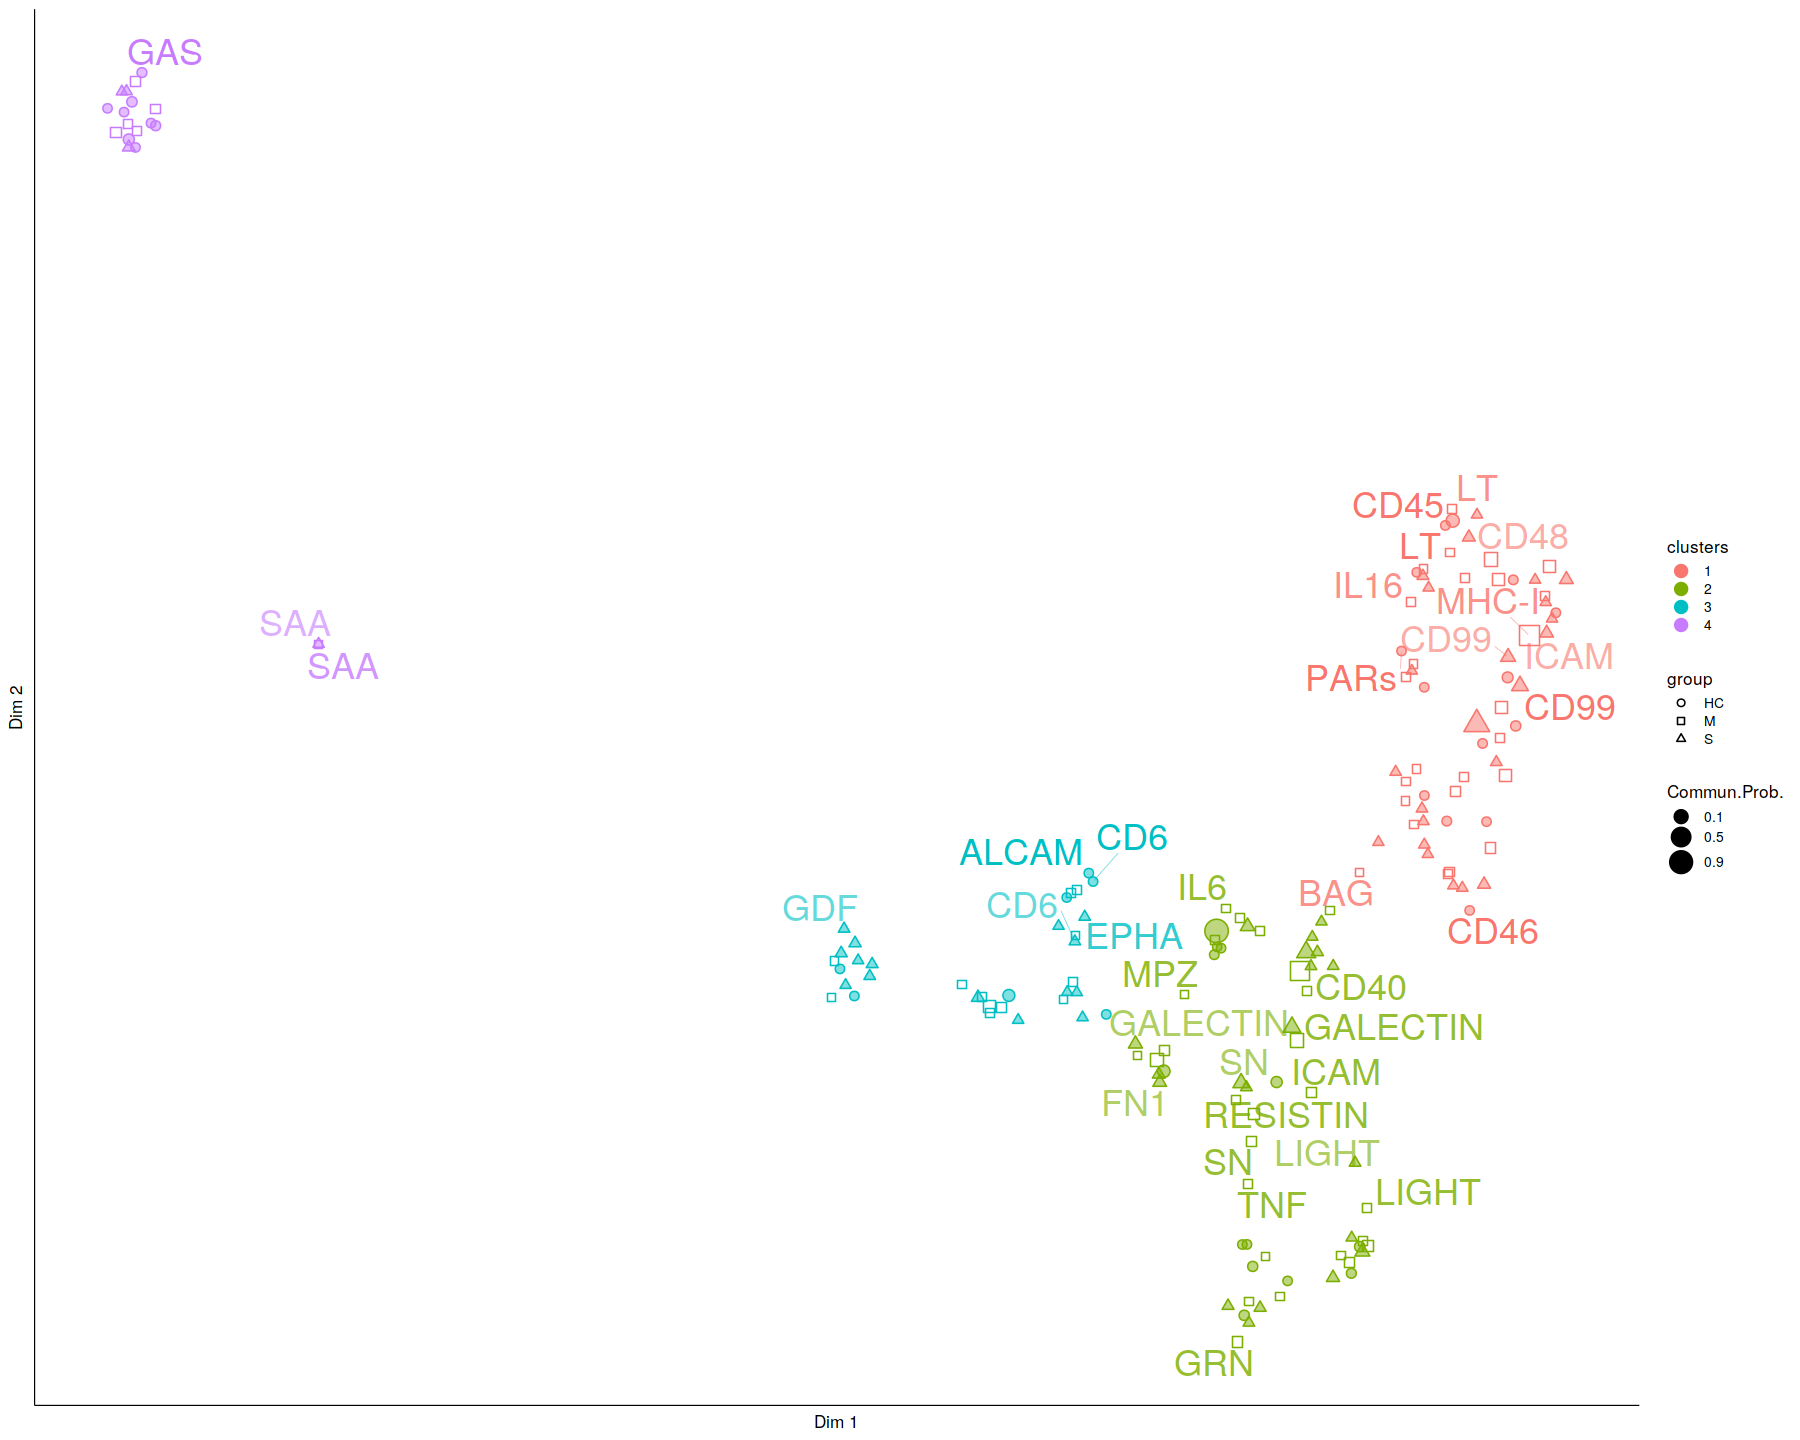

In [191]:
h_ = 12
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)
g<-netVisual_embeddingPairwise(covid, type = "functional", label.size = 7.5, do.label=T)
ggsave(paste0(rev_path, 'figures/cellchat_merged_umap.pdf'), g, height = h_, width = w_)
g

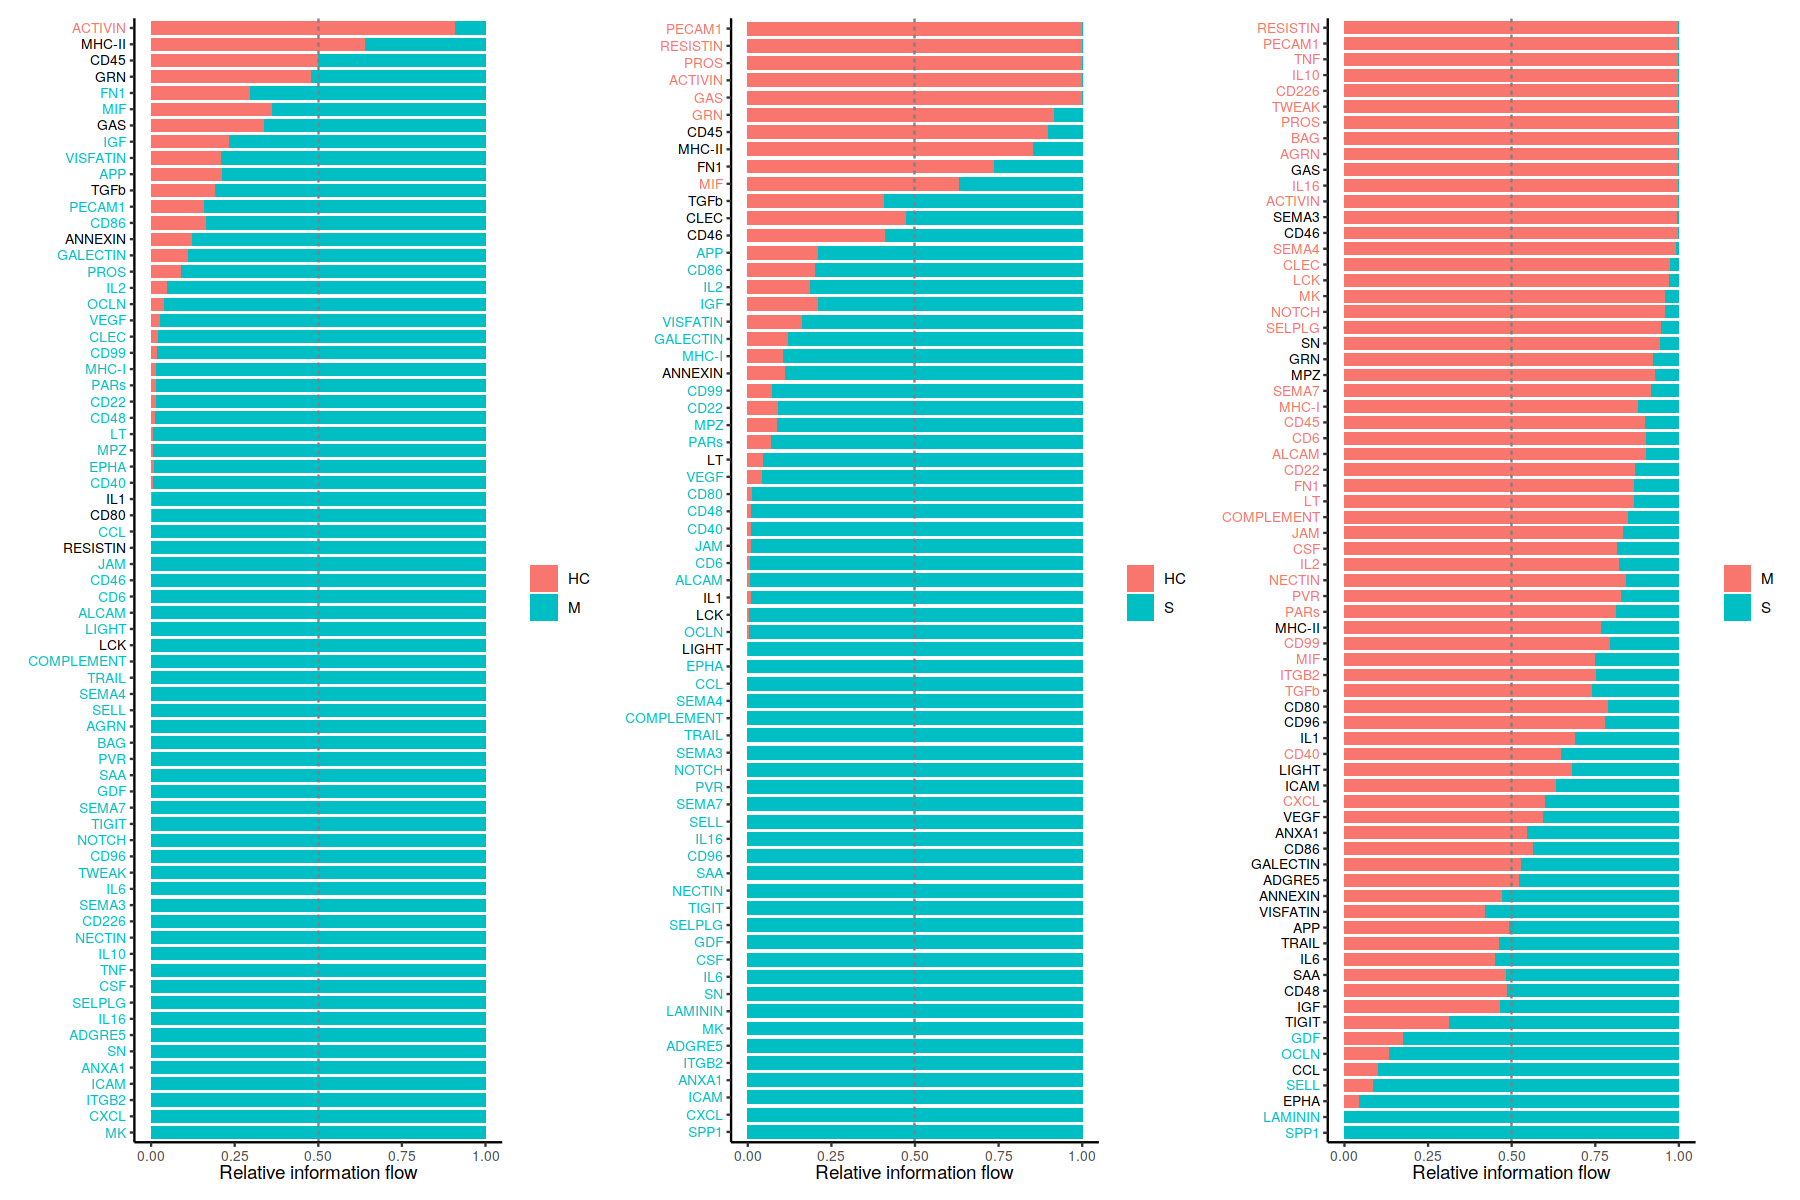

In [213]:
h_ = 10
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)
gg1 <- rankNet(covid, mode = "comparison", comparison = c(1,2),
               stacked = T, do.stat = TRUE)
gg2 <- rankNet(covid, mode = "comparison", comparison = c(1,3),
               stacked = T, do.stat = TRUE)
gg3 <- rankNet(covid, mode = "comparison", comparison = c(2,3),
               stacked = T, do.stat = TRUE)
g<-gg1+gg2+gg3
ggsave(paste0(rev_path, 'figures/cellchat_merged_informationflow.pdf'), g, height = h_, width = w_)
g

In [192]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/hratch/anaconda3/envs/cellchat/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SeuratObject_4.0.2   Seurat_4.0.3         data.table_1.14.0   
 [4] Matrix_1.3-4         RhpcBLASctl_0.20-137 patchwork_1.1.1     
 [7] CellChat_1.0.0       Biobase_2.52.0       BiocGenerics_0.38.0 
[10] ggplot2_3.3.5        igraph_1.2.6         dplyr_1.0.7         

loaded via a nam